# Pipeline
in this file we build a pipeline to 
- load (local) fmnist csv dataset
- preprocess 
    - normalize 
    - convert to np 
- and train an AE (simple conv, some casual architechture). 

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## import data

import csv as data frame (pandas) and convert to nparray

In [2]:
df_train = pd.read_csv('archive/fashion-mnist_train.csv') # df for dataframe
df_test = pd.read_csv('archive/fashion-mnist_test.csv')


separate labels
X_train.pop pops specific features (original feature is deleted in X_train)

In [3]:
labels_train = df_train.pop('label')
labels_test = df_test.pop('label')
#labels_train

create sklearn pipeline for normalizing

In [5]:
#normalize = Pipeline(steps = ['minmax_normalize', MinMaxScaler()]) # choose transform

In [5]:
normalize = MinMaxScaler() # choose transform
normalize.fit(df_train); # fit transform
df_train_normalized = np.single(normalize.transform(df_train)) # is np.single() command necessary? 
df_test_normalized = np.single(normalize.transform(df_test))

reshape from vector to img

In [6]:
X_train = df_train_normalized.reshape(-1,28,28)
X_test = df_test_normalized.reshape(-1,28,28)

## build AE
design AE as specific architecture 
    right now: simple layer


In [7]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [14]:
input_img = Input(shape=(28,28,1))
regularizer = regularizers.l1(10e-5)
# model: encoder
encoded = Conv2D(32, (3, 3), activation='relu', 
                                padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', 
                                padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
encoded = Flatten()(encoded)
#encoded = Dense(32, activation='relu')(encoded)
encoder = Model(input_img, encoded)

input_encoded = Input(shape=(196,))
encoder.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 4)           580       
_________________________________________________________________
flatten_1 (Flatten)          (None, 196)               0   

In [15]:
# model: decoder
#decoded = Dense(784, activation='relu')(input_encoded)
decoded = Reshape((7,7,4))(input_encoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3, 3), activation='relu', 
                                padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
decoder = Model(input_encoded, decoded)

decoder.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 196)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 16)          592       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 1)         289 

In [16]:
# model: autoencoder (encoder + decoder)
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.002)

autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

#autoencoder.summary()

## train AE

In [17]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0003)
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping], # stop the training when no improvements are made
                verbose=1)

Epoch 1/50
235/235 [==============================] - 3s 11ms/step - loss: 0.2585 - val_loss: 0.2572
Epoch 2/50
235/235 [==============================] - 3s 11ms/step - loss: 0.2584 - val_loss: 0.2567
Epoch 3/50
235/235 [==============================] - 3s 11ms/step - loss: 0.2583 - val_loss: 0.2568
Epoch 4/50
235/235 [==============================] - 3s 11ms/step - loss: 0.2582 - val_loss: 0.2572


In [22]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

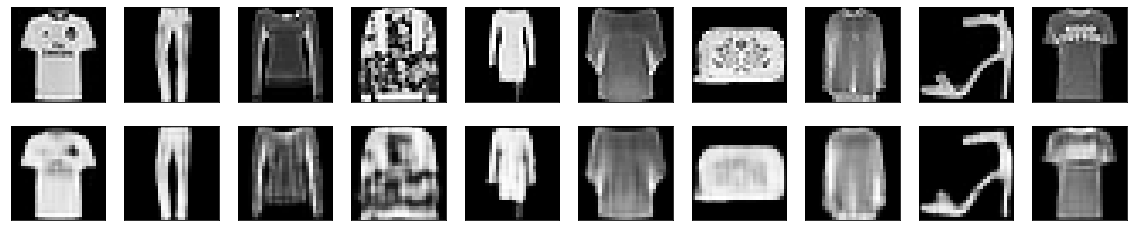

In [23]:
import matplotlib.pyplot as plt

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## combinging labels


In [43]:
df_decoded_imgs = pd.DataFrame(data=decoded_imgs.reshape(-1,784))
#df_decoded_imgs = df_decoded_imgs.join(labels_test)
#df_decoded_imgs

filter by categories

In [56]:
decoded_imgs_0 = decoded_imgs[labels_test==0]
decoded_imgs_1 = decoded_imgs[labels_test==1]
decoded_imgs_2 = decoded_imgs[labels_test==2]
decoded_imgs_3 = decoded_imgs[labels_test==3]
decoded_imgs_4 = decoded_imgs[labels_test==4]

decoded_imgs_5 = decoded_imgs[labels_test==5]
decoded_imgs_6 = decoded_imgs[labels_test==6]
decoded_imgs_7 = decoded_imgs[labels_test==7]
decoded_imgs_8 = decoded_imgs[labels_test==8]
decoded_imgs_9 = decoded_imgs[labels_test==9]



In [57]:
original_imgs_0 = X_test[labels_test==0]
original_imgs_1 = X_test[labels_test==1]
original_imgs_2 = X_test[labels_test==2]
original_imgs_3 = X_test[labels_test==3]
original_imgs_4 = X_test[labels_test==4]

original_imgs_5 = X_test[labels_test==5]
original_imgs_6 = X_test[labels_test==6]
original_imgs_7 = X_test[labels_test==7]
original_imgs_8 = X_test[labels_test==8]
original_imgs_9 = X_test[labels_test==9]


show by categories

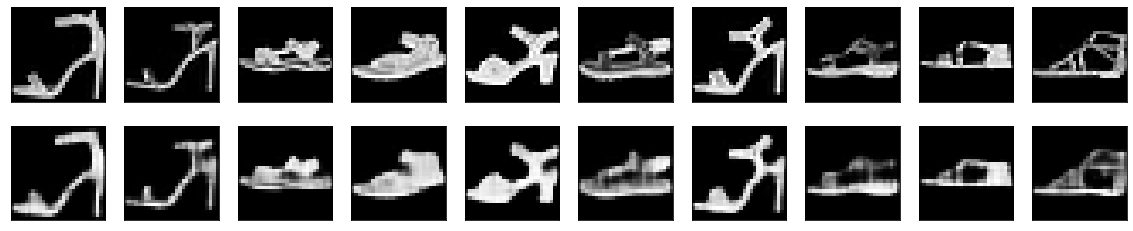

In [63]:

n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(X_test_normalized[i].reshape(28, 28))
    plt.imshow(original_imgs_5[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_5[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()